In [33]:
#Basic
import pandas as pd
import numpy as np
import os
import sys
#print(sys.executable)

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Text Processing
from sklearn.feature_extraction.text import CountVectorizer

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [34]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
type(df)
df.shape

(23486, 11)

In [18]:
df.info() # need to drop the index 0 column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [35]:
#Preprocessing of df, hence drop specified labels from columns
df.drop(df.columns[0],inplace=True, axis=1) # inplace=True returns None and not a copy of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


In [36]:
#Check for missing value
df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [37]:
# Remove missing values particularly from division name, class name, dept name as it wont aid in analysis. 
#The review text body needs to be complete, hence missing values in those are dropped as well
#Title wont be used in this analysis for ML modeling and eda, hence we'l drop it altogether
for item in ["Class Name","Department Name","Division Name","Review Text"]:
    df = df[df[item].notnull()]
df.isnull().sum() #no more missing values in important columns for analysis

Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                 0
Department Name               0
Class Name                    0
dtype: int64

In [38]:
df.shape

(22628, 10)

In [42]:
#Check for unique value
df.nunique()

Age                           77
Review Text                22621
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

In [40]:
#Dropping clothing id, title
df.drop(df.columns[[0, 2]], axis = 1, inplace = True) 

In [41]:
df.describe() #describing new df

,Age,Rating,Recommended IND,Positive Feedback Count
count,22628.000000,22628.000000,22628.000000,22628.000000
mean,43.282880,4.183092,0.818764,2.631784
std,12.328176,1.115911,0.385222,5.787520
min,18.000000,1.000000,0.000000,0.000000
25%,34.000000,4.000000,1.000000,0.000000
50%,41.000000,5.000000,1.000000,1.000000
75%,52.000000,5.000000,1.000000,3.000000
max,99.000000,5.000000,1.000000,122.000000


Visualization

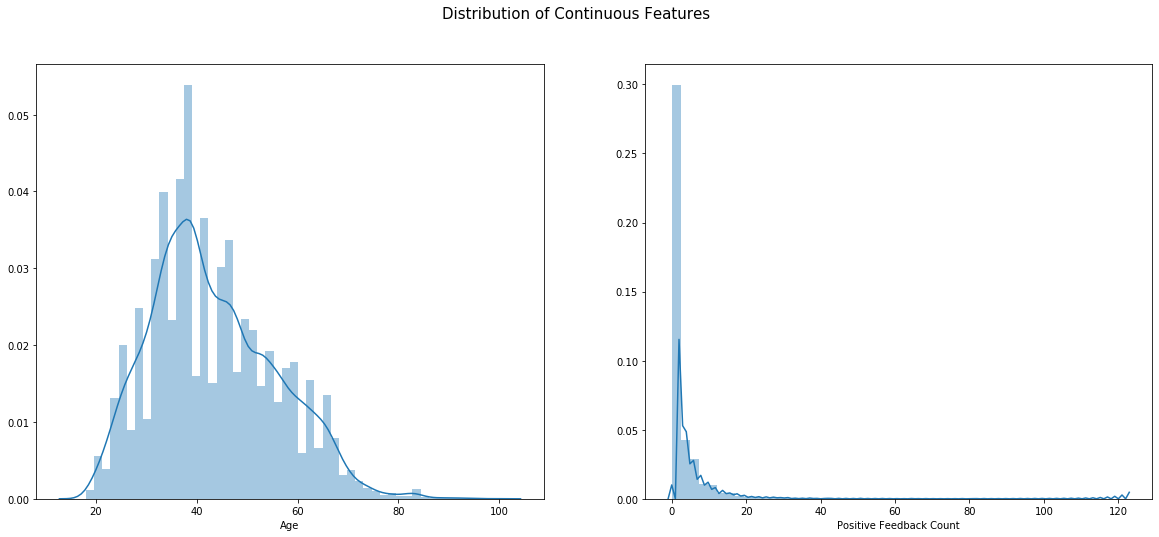

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(df["Age"], ax=ax[0])
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
fig.suptitle('Distribution of Continuous Features', fontsize=15);

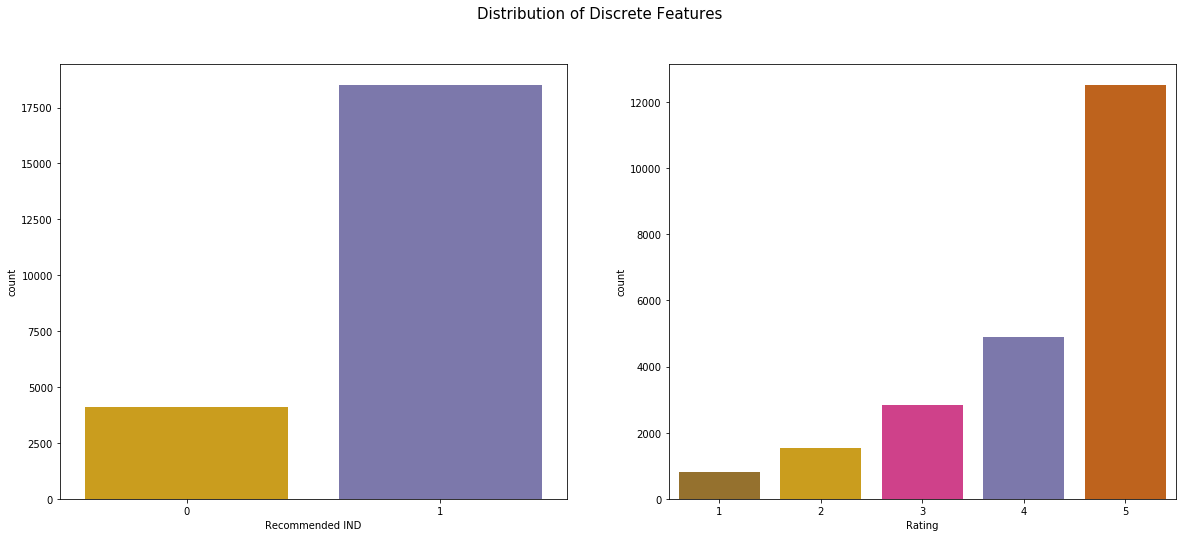

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.catplot(x="Recommended IND", kind = "count", palette=("Dark2_r"), data = df, ax=ax[0])
sns.catplot(x="Rating", kind = "count", palette=("Dark2_r"), data = df, ax=ax[1])
fig.suptitle('Distribution of Discrete Features', fontsize=15);
for i in range(2,4): 
    plt.close(i)

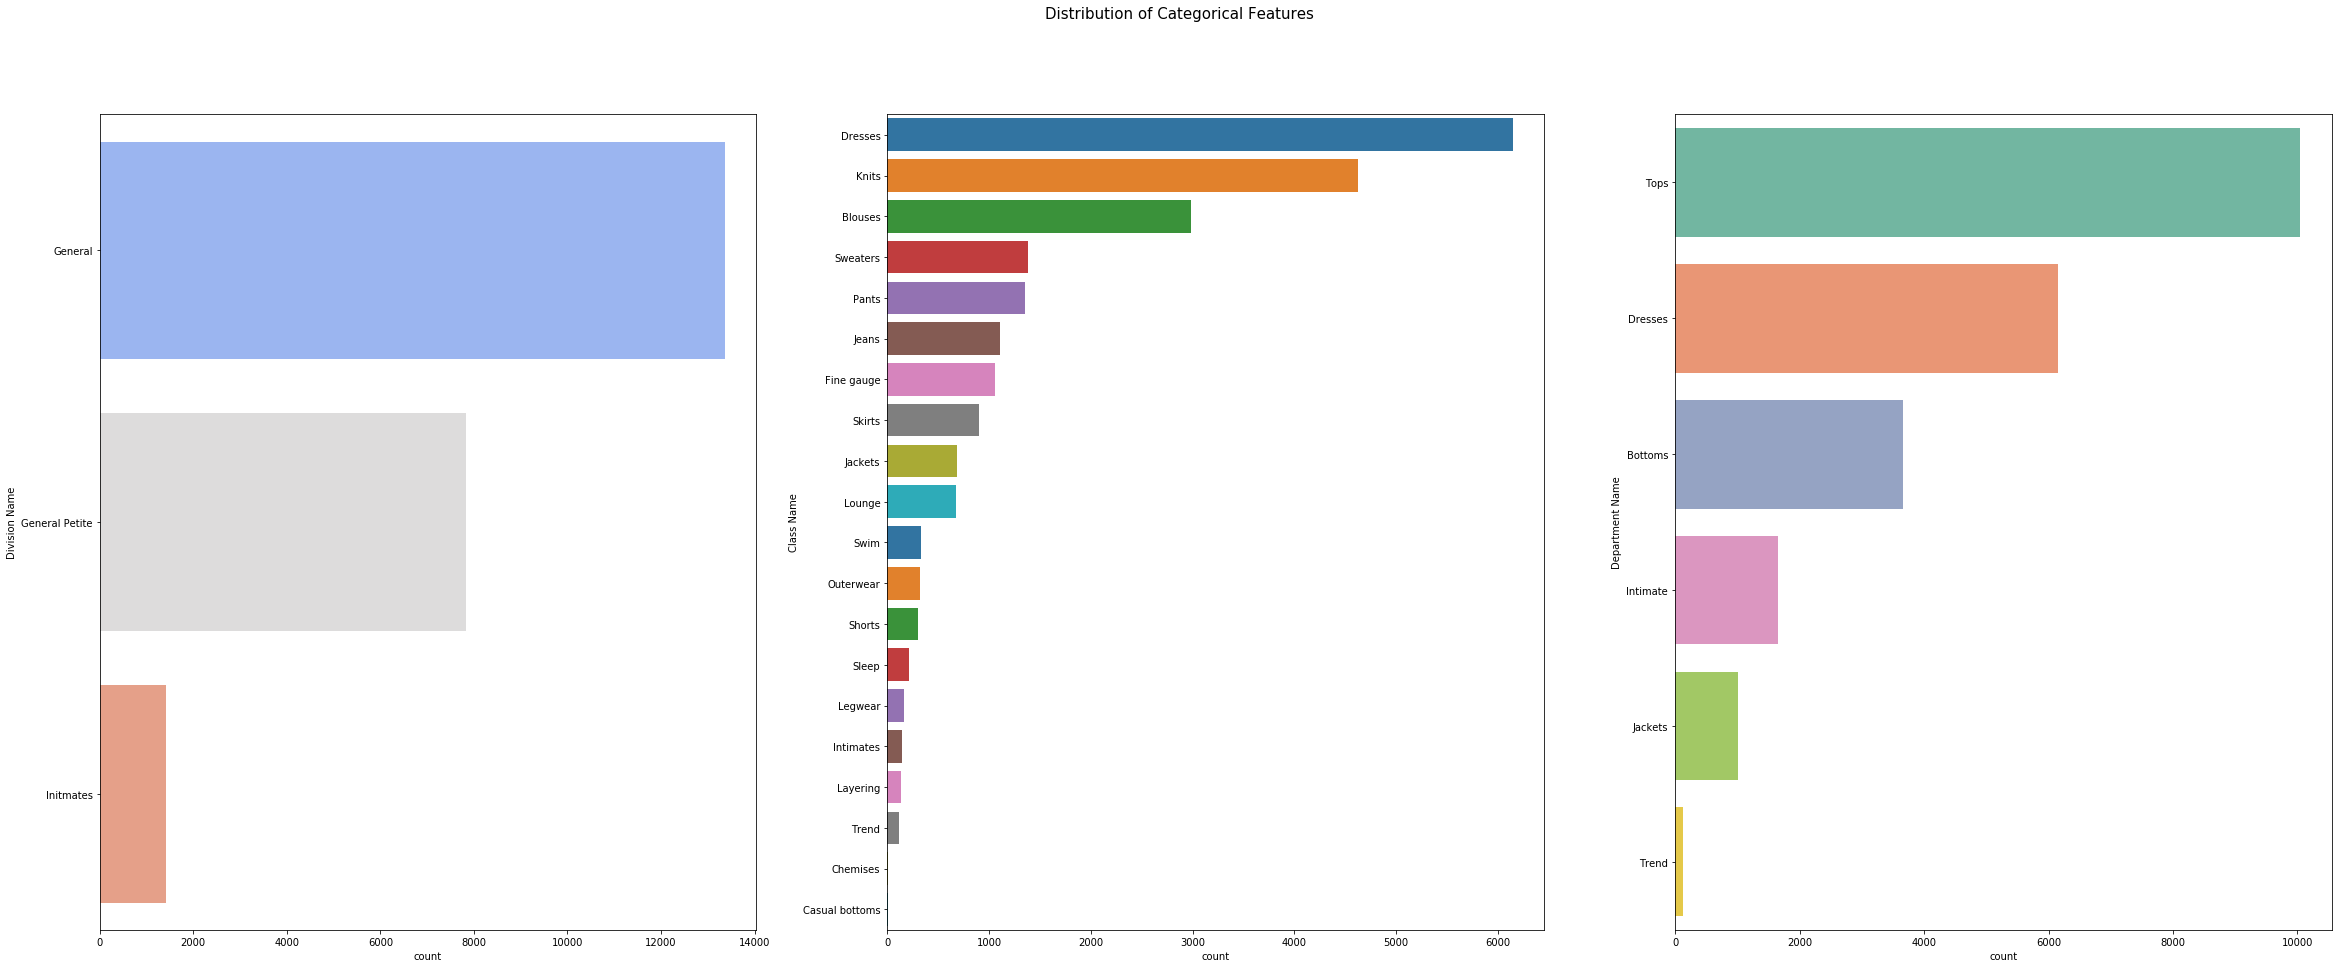

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(40, 15))
sns.countplot(y="Division Name", palette ="coolwarm",data=df, order=df["Division Name"].value_counts().index, ax=ax[0])
sns.countplot(y="Class Name", palette = "tab10", data=df, order=df["Class Name"].value_counts().index, ax=ax[1])
sns.countplot(y="Department Name", palette = "Set2",data=df, order=df["Department Name"].value_counts().index, ax=ax[2])
fig.suptitle('Distribution of Categorical Features', fontsize=15);
for i in range(2,4): 
    plt.close(i)

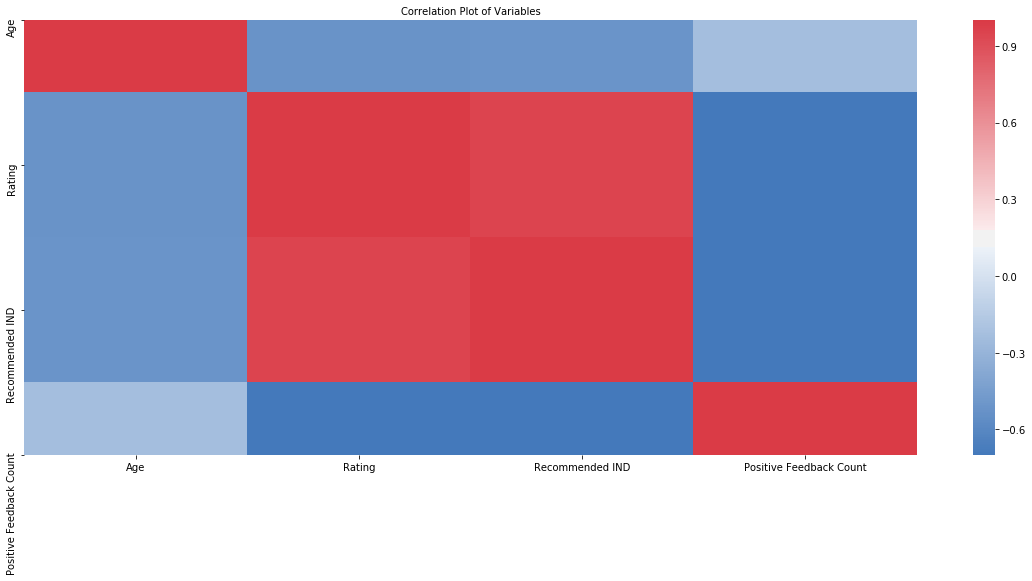

In [46]:
plt.figure(figsize=(20,8)) #can be ignored
plt.title('Correlation Plot of Variables', fontsize=10)
colormap= sns.diverging_palette(250, 10, as_cmap = True)
sns.heatmap(df.corr().astype(float).corr(),vmax=1.0, cmap = colormap)
plt.show()

In [205]:
#Adding the word counts to a dataframe is a very good practice because we might use these counts to reach some useful information. 
#To do this, I defined the function wordcounts.
# fill NA values by space
df['Review Text'] = df['Review Text'].fillna('')

# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['Review Text'].apply(wordcounts)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Counts
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


Further text editing

In [208]:
df['Sentiment'] = df['Rating'] >=3 # above 4 is true, 2 and below is false
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19805 entries, 0 to 23485
Data columns (total 12 columns):
Clothing ID                19805 non-null int64
Age                        19805 non-null int64
Title                      17198 non-null object
Review Text                19805 non-null object
Rating                     19805 non-null int64
Recommended IND            19805 non-null int64
Positive Feedback Count    19805 non-null int64
Division Name              19805 non-null object
Department Name            19805 non-null object
Class Name                 19805 non-null object
Word Counts                19805 non-null object
Sentiment                  19805 non-null bool
dtypes: bool(1), int64(5), object(6)
memory usage: 1.8+ MB


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [209]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Counts,Sentiment
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ...",True
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':...",True
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"{'and': 1, 'but': 1, 'compliments': 1, 'every'...",True
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1...",True
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,"{'0p': 1, 'alterations': 1, 'am': 1, 'and': 4,...",False


In [210]:
# prepare data for the models 
# split data
train_data,test_data = train_test_split(df,train_size=0.7,random_state=12)

In [211]:
#The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

In [216]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [221]:
predicted_logreg_model_test = lr.predict(X_test)
predicted_logreg_model_test

array([ True,  True,  True, ...,  True,  True,  True])

In [218]:
lr.score(X_test,y_test) # Testing the accuracy

0.933187478963312

In [224]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
nb_model_test = nb.predict(X_test)
nb.score(X_test,y_test) 

0.9347021204981488

In [226]:
svm = SVC()
svm.fit(X_train,y_train)
svm_model = svm.predict(X_test)
svm.score(X_test,y_test) 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8774823291820936

In [228]:
start=dt.datetime.now()
nn = MLPClassifier()
nn.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

NameError: name 'dt' is not defined